# ベイズ推論をプログラムする

## 設定
デザインAとデザインBを評価したい．

下記のレポートに基づいてAとBのクリック率についてベイズ推論により評価する．

|項目|デザインA|デザインB|
|-|-|-|
|表示回数|40|50|
|クリック数|2|4|
|クリック率|5%|8%|

## ベイズ推論のフロー
事前分布に一様分布を採用し，クリックの有無を$r$（$r=1$であればクリック有，$r=0$であればクリック無）とすると，データが生成される過程の統計モデルは以下の通り．
$$
    \theta \sim p(\theta) = Uniform(0, 1) \\
    r \sim p(r|\theta) = Bernoulli(\theta) \tag{1-1}
$$

よって，
$$
    p(\theta)=1, \
    p(r=1|\theta) = \theta, \
    p(r=0|\theta) = 1 - \theta, \\
    p(r) = \int_{-\infty}^{\infty}p(r|\theta)p(\theta)d\theta
        = \int_{0}^{1}\theta^r(1-\theta)^{1-r}d\theta = \frac{1}{2}
$$

したがって，ベイズの定理より求める事後分布は
$$
    P(\theta|r) = \frac{p(r|\theta)p(\theta)}{p(r)} = 2\theta^r(1-\theta)^{1-r}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### ベイズ更新の基本的なフローをプログラム

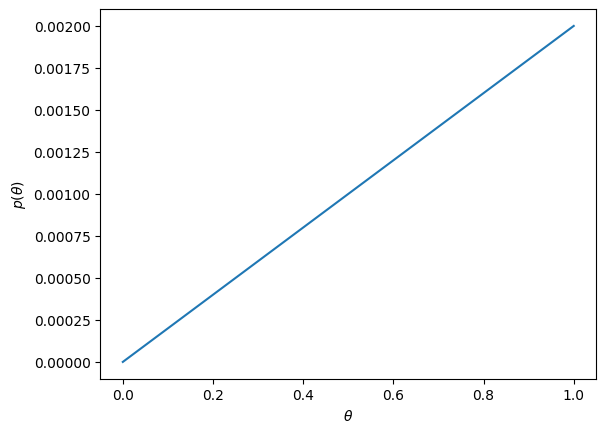

In [2]:
# 細かく刻んだ確率変数の配列を用意し，信念p(θ)を確率質量関数に近似して取り扱う
thetas = np.linspace(0, 1, 1001)

# 尤度関数を設定
likelihood = lambda r: thetas if r else 1-thetas

# 事後分布を算出する関数を作成
def posterior(r, prior):
    lp = likelihood(r) * prior
    return lp / lp.sum()

# 事前分布を一様分布として，thetaそれぞれが同じ確率を持つように確率を振り分ける
p = np.array([1/len(thetas) for _ in thetas])

# posteriorメソッドを使ってベイズ推論
p = posterior(1, p)

# 推論結果を可視化
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.show()

### ベイズ更新のフローを繰り返す

デザインA案を表示した時のクリック($r=1$)数を2回・非クリック($r=0$)数を38回を与えてベイズ更新．

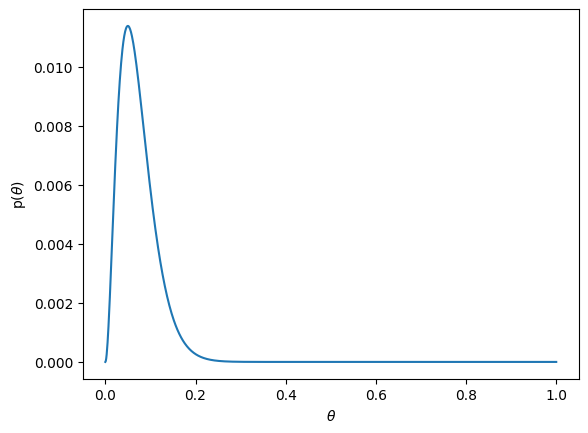

In [3]:
# クリック数・非クリック数を設定
clicks = 2
noclicks = 38

# 事前分布を設定
p = np.array([1/len(thetas) for _ in thetas])

# クリックデータ
for _ in range(clicks):
    p = posterior(1, p)

# 非クリックデータ
for _ in range(noclicks):
    p = posterior(0, p)

# 推論結果を可視化
plt.plot(thetas, p)
plt.xlabel(r'$\theta$')
plt.ylabel(r'p($\theta$)')
plt.show()

$0.05$付近を中心に裾が広がる曲線が得られた．

-> デザインAのクリック率$\theta$は$0.05$の周辺にあると考えるのが妥当だという信念が得られた．

### デザインAとBの両方についてベイズ推論を実行


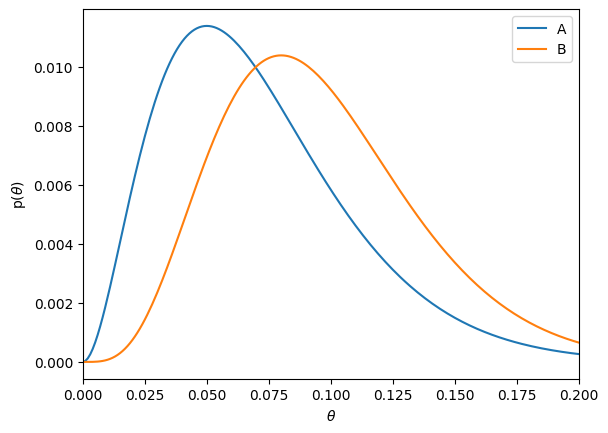

In [4]:
# デザインA
clicks_a = 2
noclicks_a = 38

p_a = np.array([1/len(thetas) for _ in thetas])

for _ in range(clicks_a):
    p_a = posterior(1, p_a)

for _ in range(noclicks_a):
    p_a = posterior(0, p_a)


# デザインB
clicks_b = 4
noclicks_b = 46

p_b = np.array([1/len(thetas) for _ in thetas])

for _ in range(clicks_b):
    p_b = posterior(1, p_b)

for _ in range(noclicks_b):
    p_b = posterior(0, p_b)

# 推論結果を可視化
plt.plot(thetas, p_a, label='A')
plt.plot(thetas, p_b, label='B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'p($\theta$)')
plt.xlim(0, 0.2)
plt.legend()
plt.show()

同じ確率でもサンプル数によってグラフの形状は異なる．

|項目|デザインA|デザインB|
|-|-|-|
|表示回数|1280|1600|
|クリック数|64|128|
|クリック率|5%|8%|

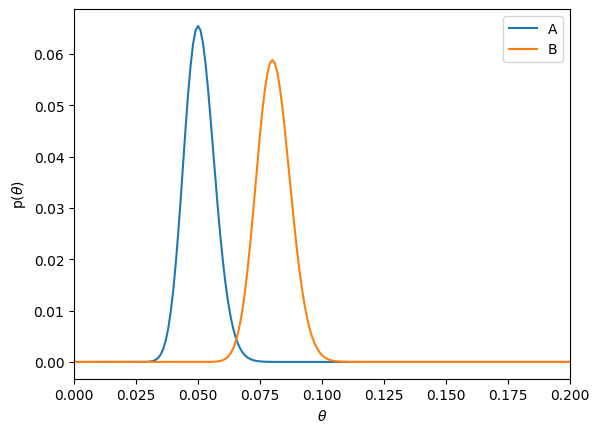

In [5]:
# デザインA
clicks_a = 64
noclicks_a = 1216

p_a = np.array([1/len(thetas) for _ in thetas])

for _ in range(clicks_a):
    p_a = posterior(1, p_a)

for _ in range(noclicks_a):
    p_a = posterior(0, p_a)


# デザインB
clicks_b = 128
noclicks_b = 1472

p_b = np.array([1/len(thetas) for _ in thetas])

for _ in range(clicks_b):
    p_b = posterior(1, p_b)

for _ in range(noclicks_b):
    p_b = posterior(0, p_b)

# 推論結果を可視化
plt.plot(thetas, p_a, label='A')
plt.plot(thetas, p_b, label='B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'p($\theta$)')
plt.xlim(0, 0.2)
plt.legend()
plt.show()

## 別解1: 二項分布を用いる
先ほどデータ生成の過程は

$$
    \theta \sim p(\theta) = Uniform(0, 1) \\
    r \sim p(r|\theta) = Bernoulli(\theta) \tag{1-1}
$$

とし，ベイズ推論をベルヌーイ試行の回数だけ繰り返したが，まとめて1回で事後分布を得る方法もある．

ここではデザインを$N$回表示した時に得られる合計クリック数$a$を考える．

各試行について，独立同一分布（i.i.d）を仮定すると，$\theta$の確率である事象が発生するベルヌーイ試行を$N$回繰り返した時，その事象が発生した合計回数$a$は，次の確率分布（二項分布）に従う．

$$
    p(a|\theta, N) = {}_N C_a \theta^a (1-\theta)^{N-a} = Binomial(\theta, N)
$$

この二項分布を使って，(1-1)式は次のように書き直すことができる．

$$
    \theta \sim Uniform(0, 1) \\
    a \sim Binomial(0, N) \tag{1-2}
$$

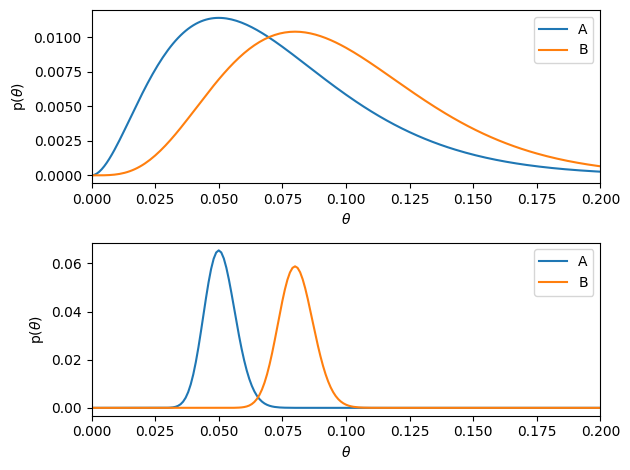

In [6]:
# 細かく刻んだ確率変数の配列を用意し，信念p(θ)を確率質量関数に近似して取り扱う
thetas = np.linspace(0, 1, 1001)

# 尤度関数を設定
likelihood = lambda a, N: thetas**a*(1-thetas)**(N-a)

# 事後分布を算出する関数を作成
def posterior(a, N, prior):
    lp = likelihood(a, N) * prior
    return lp / lp.sum()

# 事前分布の設定
prior = 1 / len(thetas)

# グラフの描画
# 1つ目のレポート
plt.subplot(2, 1, 1)
plt.plot(thetas, posterior(2, 40, prior), label='A')
plt.plot(thetas, posterior(4, 50, prior), label='B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'p($\theta$)')
plt.xlim(0, 0.2)
plt.legend()
# 2つ目のレポート
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior(64, 1280, prior), label='A')
plt.plot(thetas, posterior(128, 1600, prior), label='B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'p($\theta$)')
plt.xlim(0, 0.2)
plt.legend()
plt.tight_layout()
plt.show()

## 別解2: ベータ分布
ベータ分布

$$
    p(\theta| \alpha, \beta) = Beta(\alpha, \beta)
    = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}
    {\int_0^1 \theta^{\alpha-1} (1-\theta)^{\beta-1}d\theta}
$$

を考える．$\alpha=1, \ \beta=1$のとき$p(\theta| \alpha, \beta)=1$となり，一様分布と一致する．したがって(1-1)式は次のように書き直すこともできる．

$$
    \theta \sim Beta(1, 1) \\
    a \sim Binomial(\theta, N) \tag{1-3}
$$

また，事後分布は

$$
    p(\theta| a, N) = \frac{\theta^{a}(1-\theta)^{N-a}}
    {\int_0^1 \theta^{a} (1-\theta)^{N-a}d\theta}
$$

であるから，次のように表すことができる．

$$
    \theta|a, N \sim Beta(a+1, N-a+1)
$$

このように，ある尤度関数に対して事後分布も事前分布と同じ種類の確率分布で表される事前分布のことを**共役事前分布（conjugate prior）**と呼ぶ．

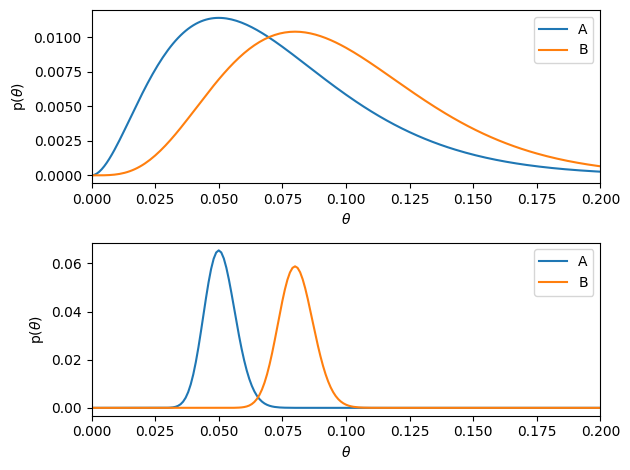

In [7]:
# 細かく刻んだ確率変数の配列を用意し，信念p(θ)を確率質量関数に近似して取り扱う
thetas = np.linspace(0, 1, 1001)

# ベータ分布を表す関数
def betaf(alpha, beta):
    numerator = thetas**(alpha-1)*(1-thetas)**(beta-1)
    return numerator / numerator.sum()

# 事後分布を算出する関数
def posterior(a, N):
    return betaf(a+1, N-a+1)

# グラフの描画
# 1つ目のレポート
plt.subplot(2, 1, 1)
plt.plot(thetas, posterior(2, 40), label='A')
plt.plot(thetas, posterior(4, 50), label='B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'p($\theta$)')
plt.xlim(0, 0.2)
plt.legend()
# 2つ目のレポート
plt.subplot(2, 1, 2)
plt.plot(thetas, posterior(64, 1280), label='A')
plt.plot(thetas, posterior(128, 1600), label='B')
plt.xlabel(r'$\theta$')
plt.ylabel(r'p($\theta$)')
plt.xlim(0, 0.2)
plt.legend()
plt.tight_layout()
plt.show()

## HDIを用いた仮説検定
HDI（Highest Density Interval）は連続確率分布に対して定義される値であり，あらゆる確率変数の値を確率密度が大きいものから順にある確立に至るまでカバーしたもの．

一般に，確率分布$p(x)$の$\alpha$%HDIは，ある閾値$t$が以下を満たすとして

$$
    \int_{p(x)>t}p(x)dx = \frac{\alpha}{100}
$$

その閾値$t$より確率密度が大きい区間$p(x)>t$として表される．

事後分布からHDIを求めることでさまざまな意思決定に利用することができる．

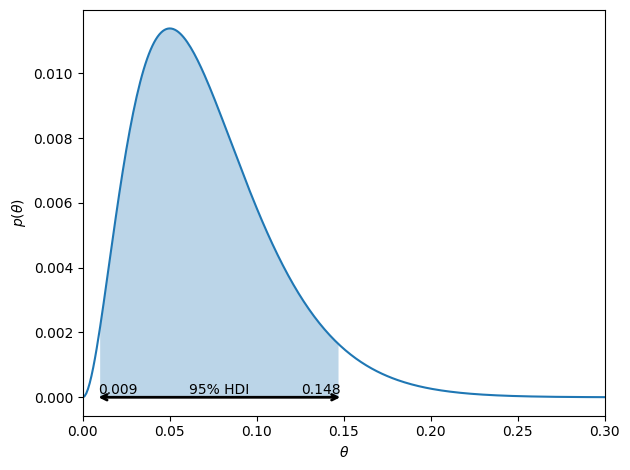

In [8]:
# 確率質量ランキング上位の値の列を返すメソッド
def hmv(xs, ps, alpha=0.95):
    xps = sorted(zip(xs, ps), key=lambda xp: xp[1], reverse=True)
    xps = np.array(xps)
    xs = xps[:, 0]
    ps = xps[:, 1]
    return np.sort(xs[np.cumsum(ps) <= alpha])

# ベータ分布を用いて事後分布を算出
thetas = np.linspace(0, 1, 1001)

def posterior(a, N):
    alpha = a + 1
    beta = N - a + 1
    numerator = thetas**(alpha-1)*(1-thetas)**(beta-1)
    return numerator / numerator.sum()

ps = posterior(2, 40)

# hmvメソッドを用いて確率質量ランキングが上位の配列を出力
hm_thetas = hmv(thetas, ps, alpha=0.95)
plt.plot(thetas, ps)
plt.annotate('', xy=(hm_thetas.min(), 0), xytext=(hm_thetas.max(), 0),
             arrowprops=dict(color='black',
                             shrinkA=0,
                             shrinkB=0,
                             arrowstyle='<->',
                             linewidth=2))
plt.annotate('%.3f' % hm_thetas.min(), xy=(hm_thetas.min(), 0), ha='left', va='bottom')
plt.annotate('%.3f' % hm_thetas.max(), xy=(hm_thetas.max(), 0), ha='right', va='bottom')
plt.annotate('95% HDI', xy=(hm_thetas.mean(), 0), ha='center', va='bottom')
hm_region = (hm_thetas.min() < thetas) & (thetas < hm_thetas.max())
plt.fill_between(thetas[hm_region], ps[hm_region], 0, alpha=0.3)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.xlim(0, 0.3)
plt.tight_layout()
plt.show()

最初のレポートのデザインAのクリック率の95%HDIは，おおよそ0.009から0.148の区間となることが分かる.

同様の手順で，最初のレポートのデザインBや2つ目のレポートのデザインA・BについてもHDIを求める．

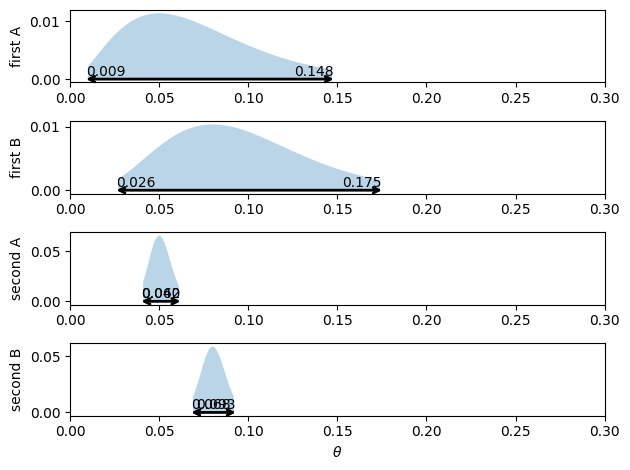

In [9]:
# 95%HDIを可視化する関数
def plot_hdi(ps, label):
    hm_thetas = hmv(thetas, ps, 0.95)
    plt.annotate('', xy=(hm_thetas.min(), 0), xytext=(hm_thetas.max(), 0),
                arrowprops=dict(color='black',
                                shrinkA=0,
                                shrinkB=0,
                                arrowstyle='<->',
                                linewidth=2))
    plt.annotate('%.3f' % hm_thetas.min(), xy=(hm_thetas.min(), 0), ha='left', va='bottom')
    plt.annotate('%.3f' % hm_thetas.max(), xy=(hm_thetas.max(), 0), ha='right', va='bottom')
    hm_region = (hm_thetas.min() < thetas) & (thetas < hm_thetas.max())
    plt.fill_between(thetas[hm_region], ps[hm_region], 0, alpha=0.3)
    plt.xlim(0, 0.3)
    plt.ylabel(label)
    plt.yticks()

# グラフの描画
plt.subplot(4, 1, 1)
first_a = posterior(2, 40)
plot_hdi(first_a, 'first A')

plt.subplot(4, 1, 2)
first_b = posterior(4, 50)
plot_hdi(first_b, 'first B')

plt.subplot(4, 1, 3)
second_a = posterior(64, 1280)
plot_hdi(second_a, 'second A')

plt.subplot(4, 1, 4)
second_b = posterior(128, 1600)
plot_hdi(second_b, 'second B')

plt.xlabel(r'$\theta$')
plt.tight_layout()
plt.show()

仮説: デザインBのクリック率は5%よりも大きい

-> デザインBのクリック率の95%HDIの最小値は5%より大きい

検定したい内容によっては，HDIの最小値が5%前後0.5%，すなわち，[4.5, 5.5]は実質5%と考え，この区間とHDIを比較する方法も考える（このような「実質同じ」区間は，**ROPE（Region Of Practical Equivalence）**と呼ぶ）

このROPEとHDIに対して以下のような意思決定ルールを適用し「あるパラメータがある対象値と等しい」という仮説を検証する．
- 対象値のROPE全体がHDIの外にあるとき，その対象値を棄却する（異なると結論づける）
- 対象値のROPEの中にHDI全体が含まれる時，その値を採用する（等しいと結論づける）
- その他の場合は，結論づけることを控える

したがって，最初のレポートの場合
- デザインAの95%HDIは[0.009, 0.148]
- デザインBの95%HDIは[0.026, 0.175]

となるため，AとBのクリック率の大小は結論づけられない．

一方，2つ目のレポートの場合
- デザインAの95%HDIは[0.040, 0.062]
- デザインBの95%HDIは[0.068, 0.093]

となるため，Bのクリック率がAよりも大きいと結論づけられる．

### 新たな確率変数を導入して仮設検定を行う
仮説: デザインBのクリック率はデザインAよりも大きい
-> AとBのクリック率の差，すなわち，

$$
    \delta = \theta_B - \theta_A
$$

に注目する．

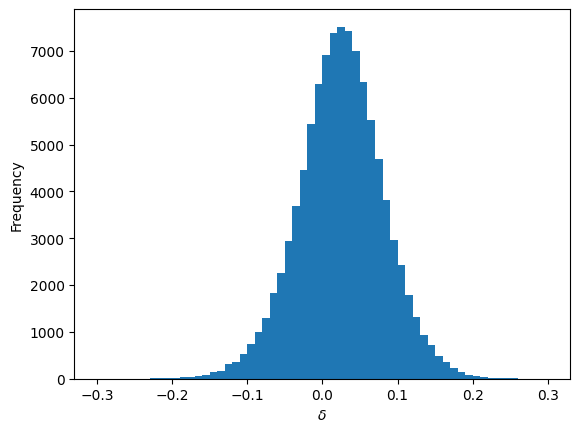

In [10]:
# 最初のレポートのクリック率の差を表す確率変数δのヒストグラム
theta_a = np.random.beta(3, 39, size=100000)
theta_b = np.random.beta(5, 47, size=100000)
delta = theta_b - theta_a
plt.hist(delta, range=(-0.3, 0.3), bins=60)
plt.xlabel(r'$\delta$')
plt.ylabel('Frequency')
plt.show()

仮説 <-> $\delta$が95%の確率で正の値になる

この仮説が正しいかどうかを検証する．

In [11]:
print((delta > 0).mean())

0.68264


0.95に満たないため，仮説が正しいとは言えない（大小を結論づけることはできない）